### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1) $-\frac{\partial L}{\partial a(x_i)}\ =\ -\frac{\partial L}{\partial a(x_i)}(y_i - a(x_i)) ^ 2\ =\ 2\cdot(y_i\ -\ a(x_i))$\
2) $-\frac{\partial L}{\partial a(x_i)}\ =\ -\frac{\partial L}{\partial a(x_i)}exp( -a(x_i) y_i)\ =\ y_i\cdot exp( -a(x_i) y_i)$\
3) $-\frac{\partial L}{\partial a(x_i)}\ =\ -\frac{\partial L}{\partial a(x_i)}\log (1 + exp( -a(x_i) y_i))\ =\ \frac{y_i\cdot exp( -a(x_i) y_i)}{1\ +\ exp( -a(x_i) y_i)}\ =\ \frac{y_i}{1\ +\ exp(a(x_i) y_i)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1449]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [1535]:
class MyGradientBoostingClassifier():

    def __init__(self, loss="mse", learning_rate=0.01, n_estimators=100, colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
    
    def loss_grad(self, y_true, y_pred):
        if self.loss == "mse":
            return 2. * (y_true - y_pred)
        if self.loss == "exp":
            return y_true * np.exp (-y_true * y_pred)
        if self.loss == "log":
            return y_true / (1 + np.exp(y_true * y_pred))
    
    def loss_func(self, y_true, y_pred):
        if self.loss == "mse":
            return np.sum((y_true - y_pred) ** 2)
        if self.loss == "exp":
            return np.sum(np.exp (-y_true * y_pred))
        if self.loss == "log":
            return np.sum(np.log(1 + np.exp(-y_pred * y_true)))
    
    def add_loss(self, target, y, array):
        if self.loss in ["log", "exp"]:
            array.append(accuracy_score(y_pred=(target > 0).astype(int), y_true=((y / 2) + 1).astype(int)))
        else:
            array.append(accuracy_score(y_pred=np.round(target), y_true=y))
    def fit(self, X, y, X_val=[], y_val=[], base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.models = []
        self.loss_train = []
        self.masks = []
        self.y = np.array(y)
        mask_samples = np.concatenate((np.ones(int(y.shape[0] * self.subsample)), 
                                       np.zeros(y.shape[0] - int(y.shape[0] * self.subsample))))
        mask_features = np.concatenate((np.ones(int(X.shape[1] * self.colsample)), 
                                        np.zeros(X.shape[1] - int(X.shape[1] * self.colsample))))
        np.random.shuffle(mask_samples)
        np.random.shuffle(mask_features)
        if init_model:
            model = init_model()
            self.initialization = lambda X: model.predict(X)
            model.fit(X, y)
            target = model.predict(X)
        else:
            self.initialization = lambda X: np.ones(X.shape[0]) * np.mean(self.y)
            target = np.ones(y.shape) * np.mean(y)
        self.add_loss(target, y, self.loss_train)
        if len(X_val):
            target_val = self.initialization(X_val)
            self.loss_val = []
            self.add_loss(target_val, y_val, self.loss_val)
        for i in range(self.n_estimators):
            new_model = base_model(*self.args, **self.kwargs).fit(X[:, mask_features.astype(bool)], 
                                                                  self.loss_grad(y, target) * mask_samples)
            self.masks.append(mask_features.astype(bool))
            self.models.append(new_model)
            target += self.learning_rate * new_model.predict(X[:, mask_features.astype(bool)])
            self.add_loss(target, y, self.loss_train)
            if len(X_val):
                target_val += self.learning_rate * new_model.predict(X_val[:, mask_features.astype(bool)])
                self.add_loss(target_val, y_val, self.loss_val)
            np.random.shuffle(mask_samples)
            np.random.shuffle(mask_features)
        
    def predict(self, X):
        target = self.initialization(X)
        for i, model in enumerate(self.models):
            target += self.learning_rate * model.predict(X[:, self.masks[i]])
        if self.loss in ["log", "exp"]:
            return (target > 0).astype(int)
        else:
            return np.round(target)

In [1339]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [1340]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, 
                                                    test_size=0.1, 
                                                    stratify=wine.target, 
                                                    random_state=42)

In [1341]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [1319]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [1320]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [1373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    shuffle=True, 
                                                    random_state=42)
model = MyGradientBoostingClassifier(loss="mse", n_estimators=800, learning_rate=0.01)
model.fit(X_train, y_train * 2 - 1, X_val=X_test, y_val=y_test * 2 - 1)

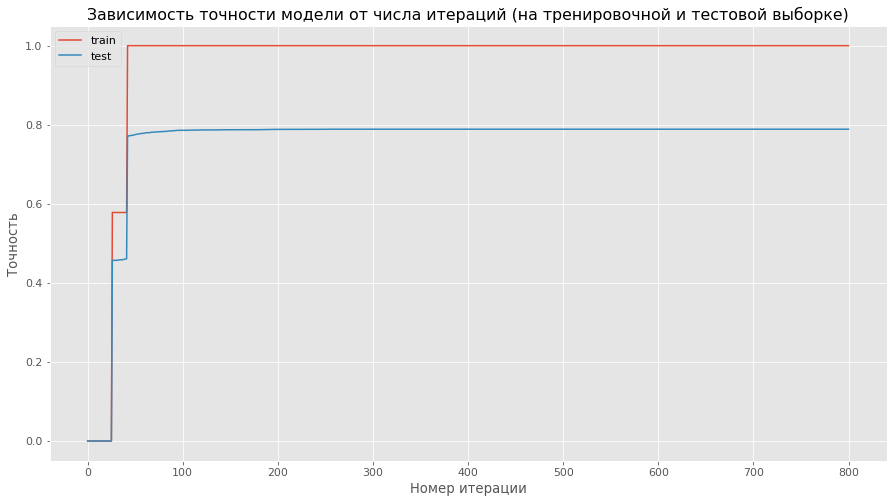

In [1374]:
plt.figure(figsize=(15, 8))
matplotlib.rc('font', size=11)
plt.plot(range(len(model.loss_train)), model.loss_train, label="train")
plt.plot(range(len(model.loss_val)), model.loss_val, label="test")
plt.legend()
plt.title("Зависимость точности модели от числа итераций (на тренировочной и тестовой выборке)")
plt.xlabel("Номер итерации")
plt.ylabel("Точность")
plt.show()

Из графика видно, что точность на валидации перестает меняться, начиная с примерно 100-ой итерцаии. Это число базовых алгоритмов и возьмем в качестве оптимального.

In [1384]:
grid = {"loss": ["exp", "log", "mse"],
        "colsample" : np.arange(0.2, 1.1, 0.2),
        "subsample" : np.arange(0.2, 1.1, 0.2)
       }
result = {}
for loss in grid["loss"]:
    for colsample in grid["colsample"]:
        for subsample in grid["subsample"]:
            model = MyGradientBoostingClassifier(learning_rate=0.1, 
                                                 n_estimators=100, 
                                                 loss=loss, 
                                                 subsample=subsample, 
                                                 colsample=colsample)
            model.fit(X_train, y_train * 2 - 1)
            result[(loss, colsample, subsample)] = accuracy_score(y_test, model.predict(X_test))

In [1390]:
best_score = 0
for params, score in result.items():
    if score > best_score:
        best_params = params
        best_score = score

In [1395]:
print(f"Лучшие параметры:\n\tloss: {best_params[0]},\n\tcolsample: {best_params[1]},\n\tsubsample: {best_params[2]}.\n"
        f"Лучший score: {best_score}")

Лучшие параметры:
	loss: exp,
	colsample: 0.8,
	subsample: 1.0.
Лучший score: 0.8837209302325582


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [1532]:
from sklearn.ensemble import RandomForestRegressor
model = MyGradientBoostingClassifier(learning_rate=0.1, 
                                         n_estimators=20, 
                                         loss=best_params[0], 
                                         subsample=best_params[1], 
                                         colsample=best_params[2],
                                         n_jobs=-1)
model.fit(X_train, (y_train * 2 - 1), base_model=RandomForestRegressor)

In [1533]:
accuracy_score(y_test, model.predict(X_test))

0.8820251937984496

In [1519]:
models = []
N = 20

for i in range(N):
    model = MyGradientBoostingClassifier(learning_rate=0.1, 
                                         n_estimators=100, 
                                         loss=best_params[0], 
                                         subsample=best_params[1], 
                                         colsample=best_params[2])
    mask = np.random.choice(np.arange(X_train.shape[0]), X_train.shape[0])
    model.fit(X_train[mask], (y_train * 2 - 1)[mask])
    models.append(model)

In [1548]:
accuracy_score(y_test, np.sum([model.predict(X_test) for model in models], axis=0) > (N / 2))

0.873062015503876

Оба подхода отработали хорошо, но не дали какого-либо улучшения. В первом случае это может быть связано с малым количеством базовых моделей, а во втором - с сэмплированием

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [1559]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
result_init = []
for init_model in [LinearRegression, SVR, RandomForestRegressor]:
    model = MyGradientBoostingClassifier(learning_rate=0.1, 
                                         n_estimators=100, 
                                         loss=best_params[0], 
                                         subsample=best_params[1], 
                                         colsample=best_params[2])
    model.fit(X_train, (y_train * 2 - 1), init_model=init_model)
    result_init.append(accuracy_score(y_test, model.predict(X_test)))
    print(f"Для init_model = {init_model.__name__} точность составила {result_init[-1]}")

Для init_model = LinearRegression точность составила 0.8917151162790697
Для init_model = SVR точность составила 0.8776647286821705
Для init_model = RandomForestRegressor точность составила 0.8849321705426356


Инициализация предсказания линейной регрессией и случайным лесом дала прирост, что говорит о хорошем начальном приближении этими моделями\
Инициализация предсказания с помощью SVM не дала прироста, что может говорить о том, что исходная константная инициализация уже давала неплохое начальное приближение

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

